In [104]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import seaborn as sns
import pickle

import numpy as np
import pandas as pd

from imblearn.under_sampling import RandomUnderSampler 
from sklearn.metrics import classification_report

sns.set_context("notebook", font_scale=1.25)

In [2]:
with open('preprocessed.pickle', 'rb') as handle:
    mydict = pickle.load(handle)
    
truth = mydict['truth']
segments = mydict['segments']
m = mydict['m']

In [3]:
mm = m.copy()

### classifier

In [404]:
mm.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

In [405]:
# minimum number of generated tokens
mm[(mm.segment=='generated')].groupby('pid').tokzero.max().min()

14

In [472]:
# beginning of generation
ds = mm[(mm.segment=='generated') & (mm.tokzero<10)][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]

In [473]:
# ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['shape', 'maxp', 'true_ent']).reset_index()
ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['maxp']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

In [474]:
ds

,run,pid,maxp0,maxp1,maxp2,maxp3,maxp4,maxp5,maxp6,maxp7,maxp8,maxp9,correct,hallucinated
0,0,9,1.0,1.000000,1.000000,0.519521,1.0,1.0,1.000000,0.631766,1.0,1.0,False,False
1,0,10,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,False,False
2,0,12,1.0,1.000000,1.000000,1.000000,1.0,1.0,0.712232,1.000000,1.0,1.0,False,False
3,0,14,1.0,1.000000,1.000000,0.594828,1.0,1.0,1.000000,0.419661,1.0,1.0,False,False
4,0,17,1.0,0.899121,0.558327,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2747,6,1788,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,True,False
2748,6,1789,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,True,False
2749,6,1790,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,False,False
2750,6,1794,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,True,False


In [475]:
ds.correct.value_counts()

correct
True     1887
False     865
Name: count, dtype: int64

In [476]:
y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

In [477]:
X.loc[:,X.nunique()!=1].shape

(2752, 10)

In [478]:
X.isnull().sum().sum() == 0

True

In [479]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
pids_res = pids[y_res.index]

In [480]:
X_res.columns = ['generated_'+col for col in X.columns]

In [481]:
X_res.isnull().sum().sum() == 0

True

### beginning of generation

In [485]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost

#partition cv by prompt
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X, y, cv=GroupKFold(n_splits=10), groups=pids)
# pred_proba = cross_val_predict(xgb_model, X, y, cv=LeaveOneGroupOut(), groups=pids, method='predict_proba')
pred_proba = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res, method='predict_proba')

CPU times: user 1.89 s, sys: 135 ms, total: 2.03 s
Wall time: 270 ms


In [489]:
pred = pred_proba.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.71      0.50      0.59       865
        True       0.61      0.79      0.69       865

    accuracy                           0.65      1730
   macro avg       0.66      0.65      0.64      1730
weighted avg       0.66      0.65      0.64      1730



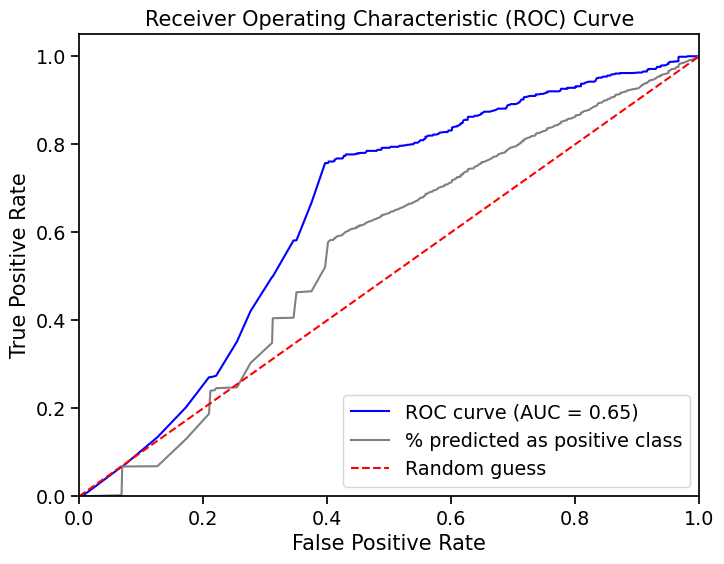

In [490]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / len(y_res.values) for thr in thresholds]

roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='grey', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [491]:
import xgboost
import shap

model = xgboost.XGBClassifier(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

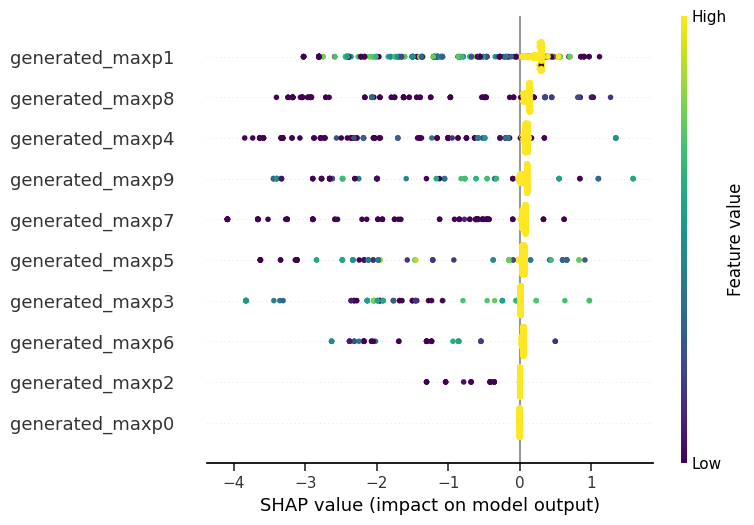

In [492]:
shap.summary_plot(shap_values, X_res, cmap="viridis")

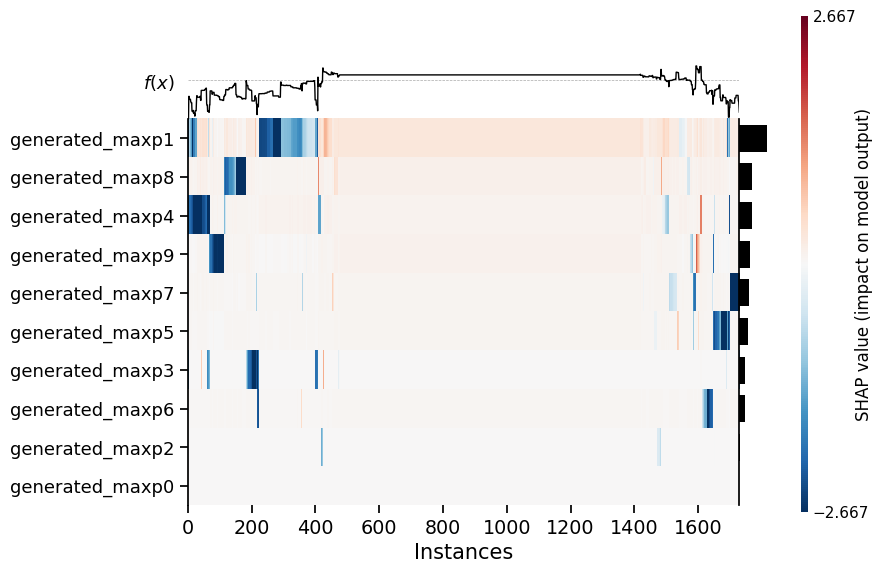

In [502]:
shap.plots.heatmap(shap_values, cmap="RdBu_r")

In [494]:
#clustering = shap.utils.hclust(X_res, y_res)
#shap.plots.bar(shap_values, clustering=clustering, max_display=20, clustering_cutoff=1)

In [495]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].astype(int)

In [496]:
vals.groupby('grp').value.sum()

grp
generated_maxp    1.0
Name: value, dtype: float64

In [497]:
K = 5
top_feat_generated_begin = vals.sort_values('value', ascending=False)[:K].label_orig.tolist()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='label', ylabel='value'>

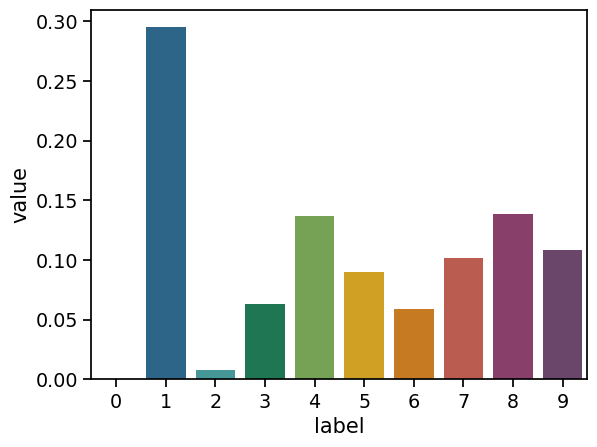

In [498]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

index_importances = vals.sort_index().groupby('label').value.sum()

sns.barplot(index_importances, palette=palette)

### end of postilla

In [326]:
mm[(mm.segment=='postilla')].tokzero.max()

64

In [327]:
# end of ...
# ds = mm[(mm.segment=='postilla') & (mm.tokzero_end>=-10)][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]

# all postilla
ds = mm[(mm.segment=='postilla')][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero_end', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
pids_res = pids[y_res.index]

X_res.columns = ['postilla_'+col for col in X.columns]

In [328]:
%%time
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)
# pred_proba_instr = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res, method='predict_proba')
pred_proba_instr = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res, method='predict_proba')

CPU times: user 26.1 s, sys: 2.66 s, total: 28.7 s
Wall time: 4.05 s


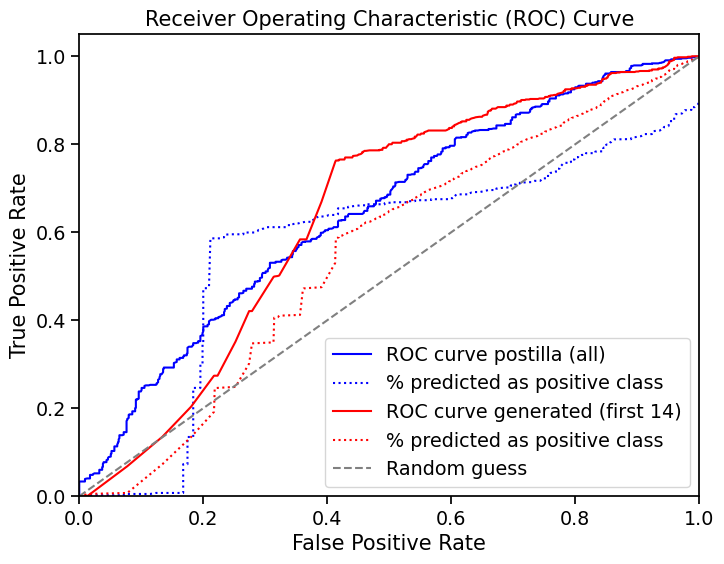

In [329]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba_instr[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba_instr.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve postilla (all)')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='red', label=f'ROC curve generated (first 14)')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [330]:
model = xgboost.XGBClassifier(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

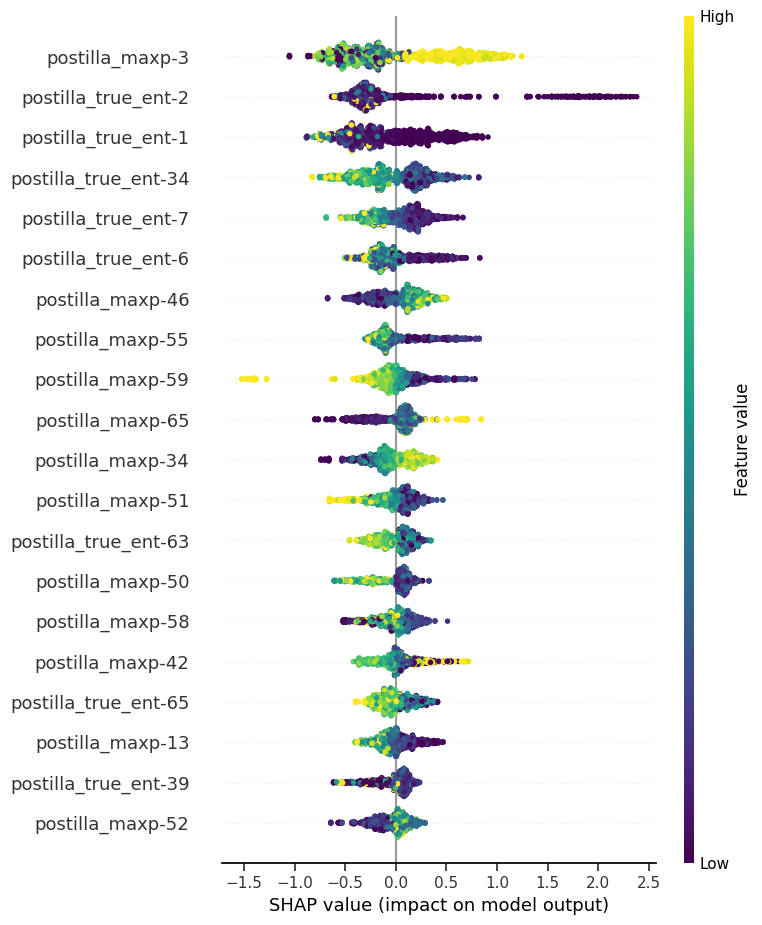

In [331]:
shap.summary_plot(shap_values, X_res, cmap="viridis")

In [332]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].astype(int)

In [333]:
K = 5
top_feat_postilla_all = vals.sort_values('value', ascending=False)[:K].label_orig.tolist()

In [334]:
vals.groupby('grp').value.sum()

grp
postilla_maxp-        0.437425
postilla_shape-       0.100736
postilla_true_ent-    0.461839
Name: value, dtype: float64



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



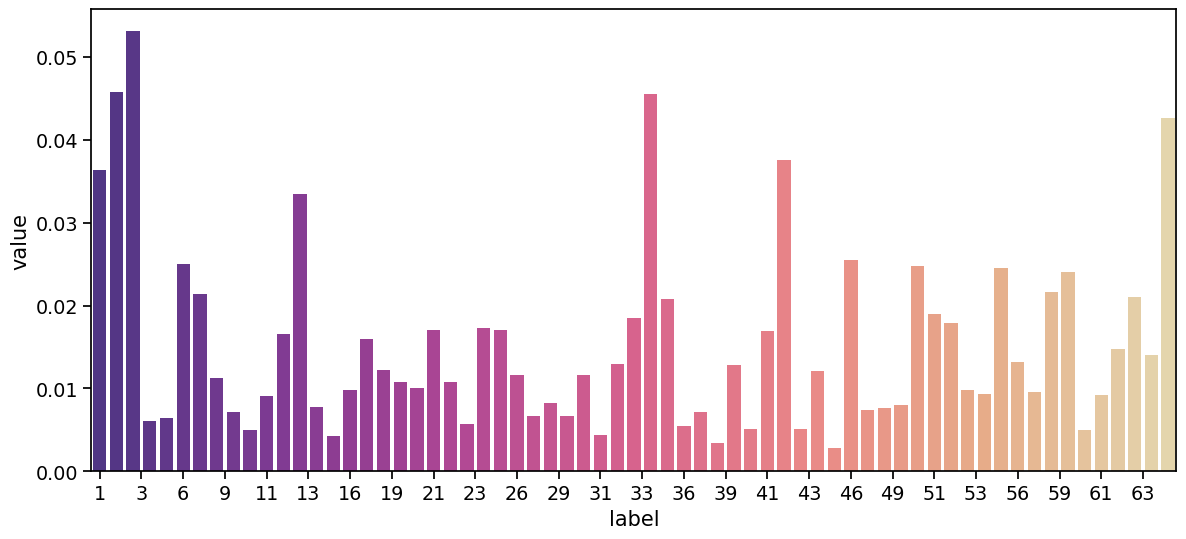

In [335]:
from matplotlib.ticker import MaxNLocator
from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.cartocolors.sequential import agSunset_7
from matplotlib.colors import LinearSegmentedColormap, Normalize


plt.figure(figsize=(14, 6))
ax = plt.gca()

index_importances = vals.sort_index().groupby('label').value.sum().to_frame().reset_index()

# palette = sns.color_palette(agSunset_7, )

norm = Normalize(vmin=0, vmax=index_importances.shape[0] - 1)
color_mapping = {str(label): agSunset_7.mpl_colormap(norm(i)) for i, label in enumerate(index_importances.label)}


sns.barplot(index_importances, x='label', y='value', palette=color_mapping, ax = ax)

ax.xaxis.set_major_locator(MaxNLocator(nbins=32))

### combo

In [336]:
mm

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end
0,0,9,0,prompt,19127,9.342692,0.011505,0,40,preamble,0,0.000000,0.000000,0,-41
6,0,9,1,prompt,4954,6.863560,0.110962,0,40,preamble,0,0.025000,0.025000,1,-40
12,0,9,2,prompt,9,1.748911,0.684082,0,40,preamble,0,0.050000,0.050000,2,-39
18,0,9,3,prompt,178,4.617726,0.093811,0,40,preamble,0,0.075000,0.075000,3,-38
24,0,9,4,prompt,5,1.100033,0.811523,0,40,preamble,0,0.100000,0.100000,4,-37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55012031,6,1797,5483,generated,1,0.000000,1.000000,5464,5487,generated,5,0.999271,5.826087,19,-5
55012037,6,1797,5484,generated,1,0.000000,1.000000,5464,5487,generated,5,0.999453,5.869565,20,-4
55012043,6,1797,5485,generated,1,0.000000,1.000000,5464,5487,generated,5,0.999636,5.913043,21,-3
55012049,6,1797,5486,generated,1,0.000000,1.000000,5464,5487,generated,5,0.999818,5.956522,22,-2


In [396]:
# COMBO
# beginning of generate + postilla

ds = mm[(mm.segment=='generated') & (mm.tokzero<=10)][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds1 = ds.merge(truth, on=['run', 'pid'])
ds1.columns = ['generated_' + col if col[-1].isdigit() else col for col in ds1.columns]

# all postilla
ds = mm[(mm.segment=='postilla')][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero_end', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds2 = ds.merge(truth, on=['run', 'pid'])
ds2.columns = ['postilla_' + col if col[-1].isdigit() else col for col in ds2.columns]

In [397]:
ds = ds1.merge(ds2, on = ['run', 'pid', 'correct', 'hallucinated'])

In [398]:
ds.shape, ds1.shape, ds2.shape

((2752, 232), (2752, 37), (2752, 199))

In [401]:
y = ds.correct
pids = ds.pid

X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

# SELETC TOP FEATURES ONLY
X = X[top_feat_postilla_all + top_feat_generated_begin]

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
pids_res = pids[y_res.index]

In [402]:
%%time
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)
pred_proba_combo = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res, method='predict_proba')

CPU times: user 3.01 s, sys: 235 ms, total: 3.24 s
Wall time: 423 ms


In [403]:
pred = pred_proba_combo.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.60      0.58      0.59       865
        True       0.59      0.61      0.60       865

    accuracy                           0.59      1730
   macro avg       0.59      0.59      0.59      1730
weighted avg       0.59      0.59      0.59      1730



In [395]:
pred = pred_proba.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.71      0.48      0.57       865
        True       0.61      0.81      0.69       865

    accuracy                           0.64      1730
   macro avg       0.66      0.64      0.63      1730
weighted avg       0.66      0.64      0.63      1730



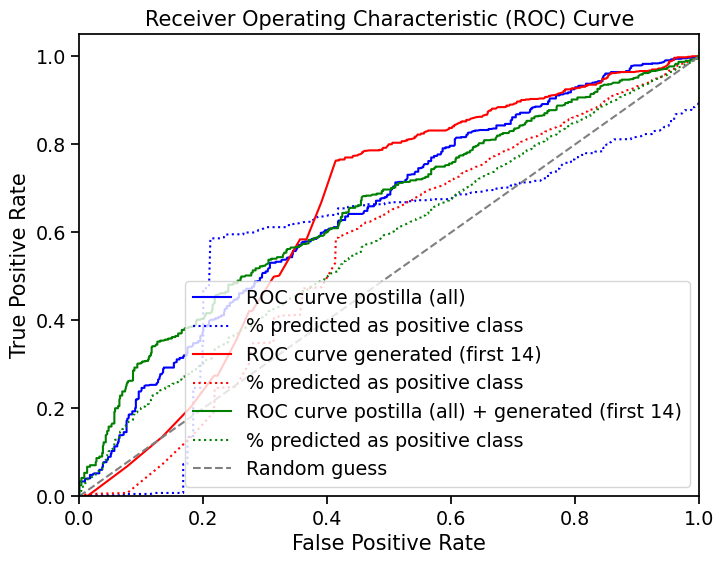

In [368]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba_instr[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba_instr.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='blue', label=f'ROC curve postilla (all)')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='red', label=f'ROC curve generated (first 14)')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba_combo[:, 1])
true_counts_rel = [(pred_proba_combo[:, 1] > thr).sum() / pred_proba_combo.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='green', label=f'ROC curve postilla (all) + generated (first 14)')
plt.plot(fpr, true_counts_rel, color='green', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [369]:
model = xgboost.XGBClassifier(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

In [374]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if (i.isdigit() or i =='-')))
vals['label'] = vals['label'].astype(int)

In [375]:
vals.groupby('grp').value.sum()

grp
generated_maxp        0.122719
generated_shape       0.017101
generated_true_ent    0.011694
postilla_maxp-        0.395252
postilla_shape-       0.089971
postilla_true_ent-    0.363263
Name: value, dtype: float64

In [376]:
vals

,label,value,label_orig,grp
98,-65,0.031133,postilla_maxp-65,postilla_maxp-
226,-2,0.029340,postilla_true_ent-2,postilla_true_ent-
12,1,0.027617,generated_maxp1,generated_maxp
194,-34,0.026261,postilla_true_ent-34,postilla_true_ent-
108,-55,0.025896,postilla_maxp-55,postilla_maxp-
...,...,...,...,...
162,-1,0.000000,postilla_maxp-1,postilla_maxp-
82,-16,0.000000,postilla_shape-16,postilla_shape-
75,-23,0.000000,postilla_shape-23,postilla_shape-
74,-24,0.000000,postilla_shape-24,postilla_shape-




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



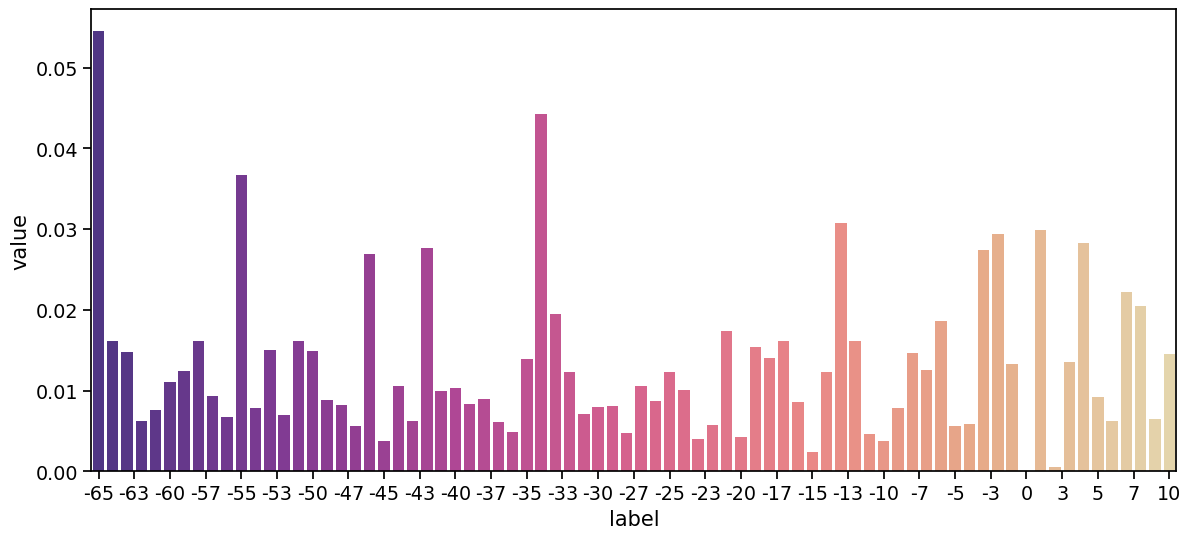

In [377]:
from matplotlib.ticker import MaxNLocator
from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.cartocolors.sequential import agSunset_7
from matplotlib.colors import LinearSegmentedColormap, Normalize


plt.figure(figsize=(14, 6))
ax = plt.gca()

index_importances = vals.sort_index().groupby('label').value.sum().to_frame().reset_index()

# palette = sns.color_palette(agSunset_7, )

norm = Normalize(vmin=0, vmax=index_importances.shape[0] - 1)
color_mapping = {str(label): agSunset_7.mpl_colormap(norm(i)) for i, label in enumerate(index_importances.label)}


sns.barplot(index_importances, x='label', y='value', palette=color_mapping, ax = ax)

ax.xaxis.set_major_locator(MaxNLocator(nbins=32))